# CNC SMS prediction: 3 month Linear combination

Иммется временной ряд отправленных СМС оповещений за 4 месяца с периодичнотью в 1 час.
Требуебся построить корректную регрессионную модель, выдать прогноз на n временных интервалов вперед и визуализировать результаты

In [2]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime
import dateutil.relativedelta

pd.options.display.float_format = '{:.3f}'.format

Populating the interactive namespace from numpy and matplotlib


Будем составлять предсказание по трем предыдущим месяцам то есть:
    $$f_t = \gamma_1 \cdot f_{t-1} + \gamma_2 \cdot f_{t-2} + \gamma_3 \cdot f_{t-3}$$
Потому что имеем только корректные данные за предыдущие 3 месяца.  
Коэффициенты $$\gamma_1, \gamma_2, \gamma_3 > 0$$ Выберем такие что:
$$\gamma_1 + \gamma_2  +\gamma_3 = 1$$
И
$$ \gamma_1 > \gamma_2 > \gamma_3 $$
То есть, последние события вносят больший вклад в предсказание

In [3]:
def one_month_linear_forecast(data, time_range):
    values = []
    for time in time_range:
        a1 = data[time - dateutil.relativedelta.relativedelta(months=1)]
        a2 = data[time - dateutil.relativedelta.relativedelta(months=2)]
        a3 = data[time - dateutil.relativedelta.relativedelta(months=3)]
        values.append(0.5 * a1 + 0.3 * a2 + 0.2 * a3)

    return pd.Series(values, index=time_range)

## Препроцесс

Загрузим входные данные и выведем некотрые статистические пказатели

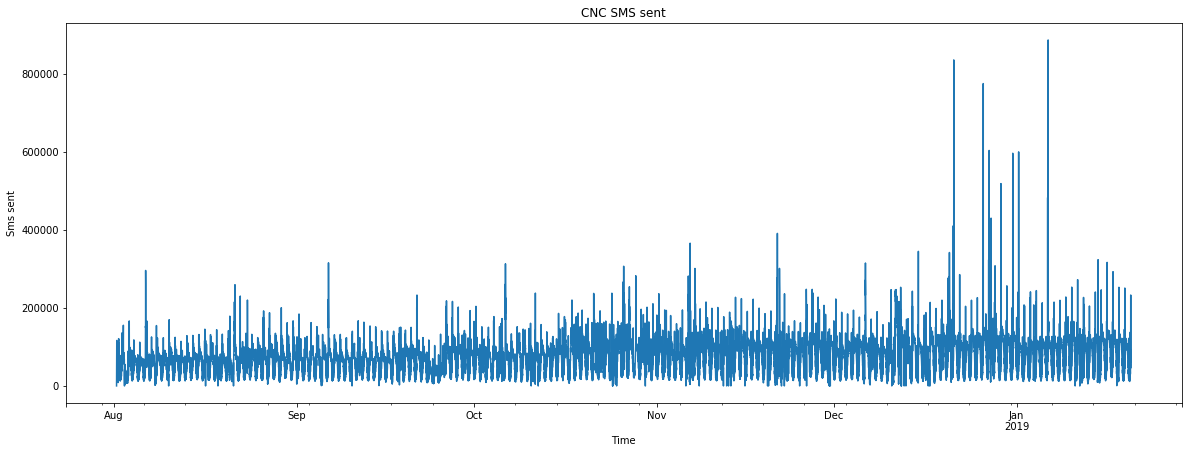

count    24768.000
mean     68637.886
std      42793.965
min          1.000
25%      30642.750
50%      68145.500
75%      96240.000
max     886752.000
Name: Value, dtype: float64


In [4]:
df = pd.read_csv('10min.csv', sep=';', index_col=['Time'], parse_dates=['Time'], dayfirst=True)
df = df.drop(df['Value'].tail(1).index)
n = int(df['Value'].size/2)
df = df[n:]
df['Value'] = df['Value'].apply(lambda text: ''.join(j for j in text if ord(j) < 128))
df['Value'] = df['Value'].apply(lambda val: float(val))
df['Value'] = df['Value'].apply(lambda val: 1 if val <= 0 else val)
df['Value'] = df['Value'].asfreq('10min', method='pad')
data = df['Value']
plt.figure(figsize(20,7))
data.plot()
plt.title("CNC SMS sent")
plt.ylabel('Sms sent')
plt.show()
    
print(data.describe())

## Модель

Проверим коррекнтость нашего метода предсказав уже известные данные за последний месяц

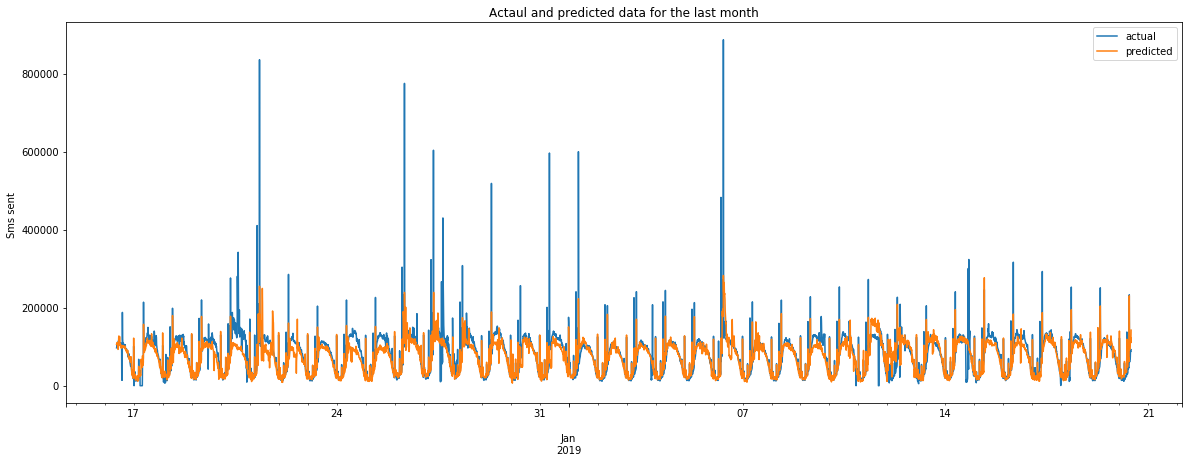

In [44]:
beg = df['Value'].index[-35*24*6]
end = df['Value'].index[-1]

dr = pd.date_range(start=beg, end=end, freq ='10min')

predicted = one_month_linear_forecast(data, dr)
actual = data[beg:]

actual = pd.Series(actual, index=dr)
predicted = pd.Series(predicted, index=dr)

plt.figure(figsize(20,7))
actual.plot(label='actual')
predicted.plot(label='predicted')
plt.title('Actaul and predicted data for the last month')
plt.legend(loc='best')
plt.ylabel('Sms sent ')
plt.show()

А теперь визуализируем меньший интревал - 1 день:

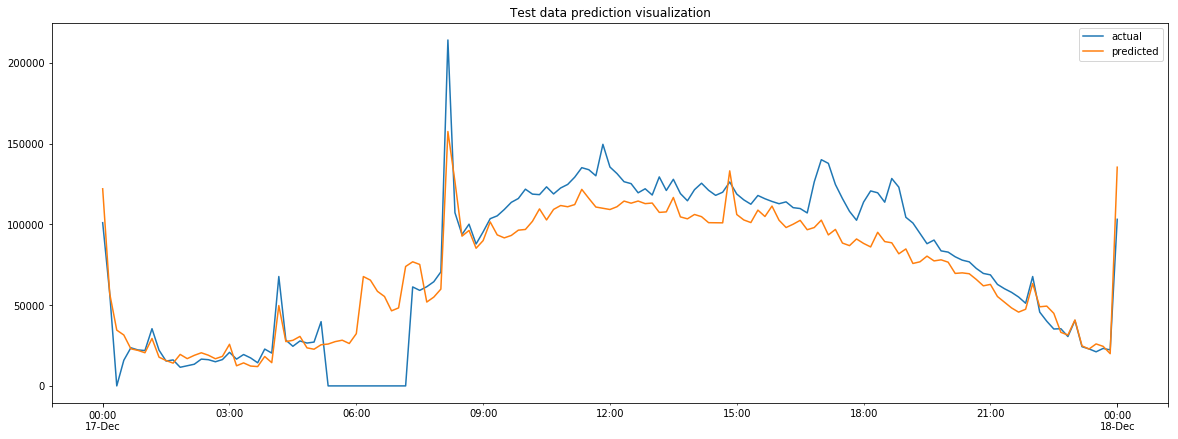

In [49]:
FROM = '2018-12-17 00:00:00'
TO = '2018-12-18 00:00:00'

actual[FROM:TO].plot(label='actual')
predicted[FROM:TO].plot(label='predicted')
plt.legend(loc='best')
plt.title('Test data prediction visualization')
plt.show()

## Прогноз

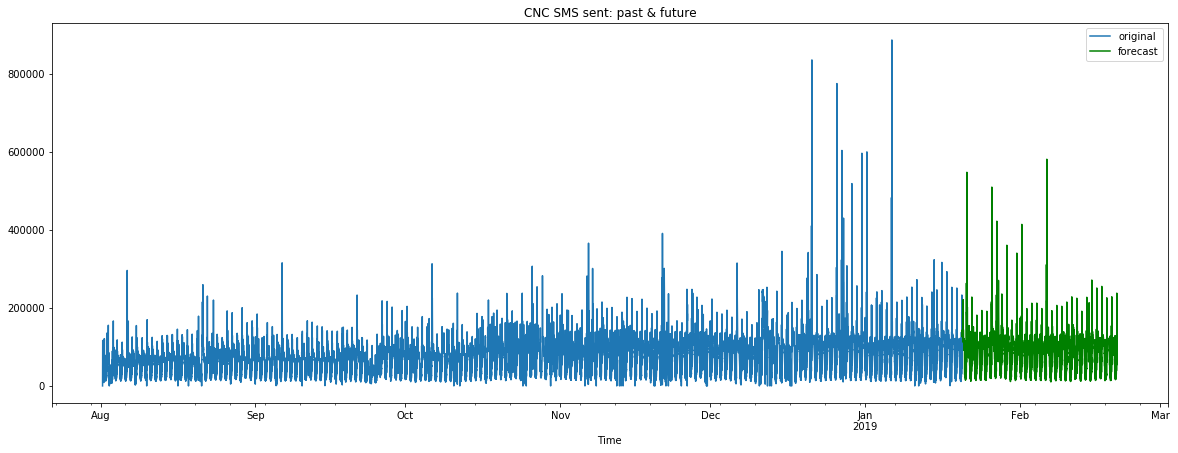

In [55]:
last_measurement = data.index[-1]

forecast_dates = pd.date_range(start=last_measurement,
                               end=last_measurement+dateutil.relativedelta.relativedelta(months=1), freq='10min')


forecast = one_month_linear_forecast(data, forecast_dates)

data.plot(label='original')
forecast.plot(label='forecast',color='green')
plt.title('CNC SMS sent: past & future')
plt.legend(loc='best')
plt.show()